In [1]:
#basics
import numpy as np 
import pandas as pd
import collections
import re
import functools
import operator
from datetime import datetime, timedelta
from accessify import protected
from copy import deepcopy

#NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from string import punctuation
nltk.download("stopwords")
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from sklearn.manifold import TSNE
from nltk import ngrams

#visualise
import matplotlib.pyplot as plt
%matplotlib inline
import chart_studio.plotly as py
#import plotly.graph_obs as go
from plotly.offline import iplot
import cufflinks as cf
import matplotlib.cm as cm
import plotly.express as px


#fastai
from sklearn.model_selection import train_test_split
import fastai
from fastai.text.transform import Tokenizer
from fastai.text.learner import text_classifier_learner
from fastai.text.models import AWD_LSTM
from fastai.text.models import awd_lstm_lm_config


#extra
noise = stopwords.words('russian') + list(punctuation)
upnoise = [letter.upper() for letter in noise]
sum_noise = noise+upnoise+['.','»','«', 'Коллега', "коллега", "это",'спасибо', 
                           'такой',"уважаемый", "квартира", "который", "свой", "пожалуйста"]
path = ''

[nltk_data] Downloading package stopwords to /home/victor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/victor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/home/victor/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning:

CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)



In [2]:
df = pd.read_csv("fb.csv", index_col=0)

In [15]:
class SentimentalModel:
    
    def __init__(self, pos='positive_senti.csv', neg='negative_senti.csv'):
        self.pos = pos
        self.neg = neg
        
    def token_text(self, text):
        return [word for word in word_tokenize(text.lower()) if word not in sum_noise]
    
    def preprocess_text(self, text):
        text = text.lower().replace("ё", "е")
        text = text.lower().replace("USER", "")
        text = text.lower().replace("rt", "")
        text = text.lower().replace("URL", "")
        text = text.lower().replace("", "")
        text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
        text = re.sub('@[^\s]+', 'USER', text)
        text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
        text = re.sub(' +', ' ', text)
        return text.strip()
    
    def create_data(self):
        n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
        data_positive = pd.read_csv(self.pos, sep=';', error_bad_lines=False, names=n, usecols=['text'])
        data_negative = pd.read_csv(self.neg, sep=';', error_bad_lines=False, names=n, usecols=['text'])

        # Формируем сбалансированный датасет
        sample_size = min(data_positive.shape[0], data_negative.shape[0])
        raw_data = np.concatenate((data_positive['text'].values[:sample_size],
                                   data_negative['text'].values[:sample_size]), axis=0)
        self.labels = [1] * sample_size + [0] * sample_size
        
        
        self.data = [self.preprocess_text(t) for t in raw_data]
        self.data_tok = pd.Series(data).apply(self.token_text)

        self.WORDS = set()
        for sent in self.data_tok:
            for w in sent:
                self.WORDS.add(w)
                
                
        df_train=pd.DataFrame(columns=['Text', 'Label'])
        df_test=pd.DataFrame(columns=['Text', 'Label'])

        df_train['Text'], df_test['Text'], df_train['Label'], df_test['Label'] = train_test_split(self.data,
                                                                                                  self.labels,
                                                                                                  test_size=0.2,
                                                                                                  random_state=1)
        
        df_val=pd.DataFrame(columns=['Text', 'Label'])
        self.df_train, self.df_val = train_test_split(df_train, test_size=0.2, random_state=1)
        
        print('data created')
        
    def fit(self):
        
        self.create_data()
        
        
        
        tokenizer=Tokenizer(lang='xx')
        data_lm = fastai.text.data.TextLMDataBunch.from_df(path, tokenizer=tokenizer,
                                                   bs=16, train_df=self.df_train, valid_df=self.df_val,
                                                           text_cols=0)
        print('batches formed')
        
        data_test_clas = fastai.text.data.TextClasDataBunch.from_df(path, vocab=data_lm.train_ds.vocab,
                                                            bs=32, train_df=df_train, valid_df=df_test,
                                                            text_cols=0, label_cols=1, tokenizer=tokenizer)
        
        
        config = fastai.text.models.awd_lstm_clas_config.copy()
        config['n_hid'] = 1150
        self.learn_test =text_classifier_learner(data_test_clas, AWD_LSTM, config=config, drop_mult=0.5)
        
        self.learn_test.load_encoder('/home/victor/fb/ft_enc')
        self.learn_test.load('/home/victor/fb/tw_lstm')
        
        print('model learned')
        
    def predict(self, obj:'str'):
        
        return self.learn_test.predict(obj)

/home/victor/anaconda3/lib/python3.7/site-packages/fastai/core.py:302: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



/home/victor/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

<string>:6: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



RNNLearner(data=TextClasDataBunch;

Train: LabelList (143260 items)
x: TextList
xxbos раньше все встречались у фонтана в гуме а теперь на съезде xxup user все классные люди сегодня будут там,xxbos ни когда не пойму любовь женщины к женщине хотя на это приятно смотреть,xxbos два сеанса в кино вот что я люблю парам пам пап едим домой и пофиг что я не высплюсь я по понедельникам всегда не высыпаюсь,xxbos я нашел мой наряд для кэти перри xxup user xxup url via xxup user,xxbos xxup user xxrep 5 у всеее развод обидки и все дела
y: CategoryList
1,1,1,1,1
Path: .;

Valid: LabelList (44770 items)
x: TextList
xxbos xxup user ну ты д читаешь мня и значит xxunk в нее,xxbos xxup user даа ща побольше хвост как у енота немного ахха,xxbos xxup user d как ты фотки присылать каждого актера d ни xxunk никому не нужно эт xxunk,xxbos xxup user скоро cкоро уже все начнут покупать новогодние елки xxup url,xxbos xxup user xxup user xxup url девы печальбеда ибо его возможно закроют когда там скрипач выступает


In [13]:
learn_test.predict('жопа')

/home/victor/anaconda3/lib/python3.7/site-packages/fastai/text/data.py:339: UserWarning:

This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)



(Category tensor(0), tensor(0), tensor([0.8200, 0.1800]))

In [16]:
class TextAnalyzer:
    def __init__(self, df):
        ##########TIME#######################
        for i in range(len(df)):
            try:
                df['time'][i] = datetime.strptime(df["time"][i], '%Y-%m-%d')
            except TypeError:
                continue
            
        self.df = deepcopy(self.tokeniz(df))
        self.df2 = deepcopy(df)
        
    @protected
    def tokeniz(self, df):

        #########COMMENTS#####################
        for i in range(len(df)):
            df["comment"][i] = list(df["comment"][i][2:-2].replace("'", '').split(','))
        tw = TweetTokenizer()
        det = TreebankWordDetokenizer()
        for i in (range(len(df))):
            for j in range(len(df["comment"][i])):
                tokenized_example = (tw.tokenize(df["comment"][i][j]))
                filtered_example = [word for word in tokenized_example if not word in sum_noise]
                df["comment"][i][j] = det.detokenize(filtered_example)
        mystem_analyzer = Mystem(entire_input=False)
        for i in (range(len(df))):
            df["comment"][i] = [mystem_analyzer.lemmatize(w) for w in df["comment"][i]]
            df["comment"][i] = list(filter(None, df["comment"][i]))
        for i in range(len(df)):
            for j in range(len(df['comment'][i])):
                df['comment'][i][j] = [word for word in df['comment'][i][j] if not word in sum_noise]


        ##########POSTS##############
        for i in (range(len(df))):
                tokenized_example = (tw.tokenize(df["post"][i]))
                filtered_example = [word for word in tokenized_example if not word in sum_noise]
                df["post"][i] = det.detokenize(filtered_example)
        for i in (range(len(df))):
            a = []
            a.append(df['post'][i])
            df["post"][i] = a
        for i in (range(len(df))):
            df["post"][i] = [mystem_analyzer.lemmatize(w) for w in df["post"][i]][0]
        for i in range(len(df)):
            df['post'][i] = [word for word in df['post'][i] if not word in sum_noise]
        
        return df
    
    @protected
    def date_slice(self, start_date = None, end_date = None):
        if start_date == None and end_date == None:
                self.df1 = deepcopy(self.df)
        
        if (type(start_date) == list or type(end_date) == list):
            if (not start_date == None ) and (not end_date==None):
                start_date = datetime(start_date[2], start_date[1], start_date[0], 0, 0)
                end_date = datetime(end_date[2], end_date[1], end_date[0], 0, 0)
                self.df1 = self.df[self.df['time']<end_date]
                self.df1 = self.df1[self.df1['time']>start_date]
            elif (not start_date == None ) and (end_date==None):
                start_date = datetime(start_date[2], start_date[1], start_date[0], 0, 0)
                self.df1 = self.df[self.df['time']>start_date]
            elif (start_date == None ) and (not end_date==None):
                end_date = datetime(end_date[2], end_date[1], end_date[0], 0, 0)
                self.df1 = self.df[self.df['time']<end_date]
        elif (type(start_date) == datetime  and type(end_date) == datetime):
            self.df1 = self.df[self.df['time']<end_date]
            self.df1 = self.df1[self.df1['time']>=start_date]
            
    @protected
    def date_slice1(self, df, start_date = None, end_date = None):
        if start_date == None and end_date == None:
                self.df1 = deepcopy(df)
        
        if (type(start_date) == list or type(end_date) == list):
            if (not start_date == None ) and (not end_date==None):
                start_date = datetime(start_date[2], start_date[1], start_date[0], 0, 0)
                end_date = datetime(end_date[2], end_date[1], end_date[0], 0, 0)
                self.df1 = df[df['time']<end_date]
                self.df1 = self.df1[self.df1['time']>start_date]
            elif (not start_date == None ) and (end_date==None):
                start_date = datetime(start_date[2], start_date[1], start_date[0], 0, 0)
                self.df1 = df[df['time']>start_date]
            elif (start_date == None ) and (not end_date==None):
                end_date = datetime(end_date[2], end_date[1], end_date[0], 0, 0)
                self.df1 = df[df['time']<end_date]
        elif (type(start_date) == datetime  and type(end_date) == datetime):
            self.df1 = df[df['time']<end_date]
            self.df1 = self.df1[self.df1['time']>=start_date]
            
    def frequency(self,  numb, text_type, start_date = None, end_date = None, ngram = 1, draw=True, output=True):
        #start&end date = [d, m ,y]
        if ngram>1:
            draw = False
        self.numb = numb
        self.wordcount = {}
        self.text_type = text_type
        self.draw = draw
        #self.start_date = start_date
        #self.end_date = end_date
       
        self.date_slice1(self.df, start_date, end_date)
        
        if self.text_type == 'comment':
            
            self.df1.index = np.arange(len(self.df1))
            if ngram>1:
                for i in range(len(self.df1)):
                    for j in range(len(self.df1['comment'][i])):
                        self.df1['comment'][i][j] = list(ngrams(self.df1['comment'][i][j],ngram))
            for i in range(len(self.df1)):
                for j in range(len(self.df1['comment'][i])):
                    for word in (self.df1['comment'][i][j]):
                       # if ngram==1:
                        #    word = word.replace(".","")
                         #   word = word.replace(",","")
                          #  word = word.replace(":","")
                           # word = word.replace("\"","")
                           # word = word.replace("!","")
                           # word = word.replace("â€œ","")
                           # word = word.replace("â€˜","")
                           # word = word.replace("*","")
                           # word = word.replace(" ","")
                        if word not in sum_noise:
                            if word not in self.wordcount.keys():
                                self.wordcount[word] = 1
                            else:
                                self.wordcount[word] += 1
        if self.text_type == 'post':
            self.df1.index = np.arange(len(self.df1))
            if ngram>1:
                for i in range(len(self.df1)):
                    self.df1['post'][i] = list(ngrams(self.df1['post'][i],ngram))
            for i in range(len(self.df1)):   
                for word in self.df1['post'][i]:
                  #  if ngram==1:
                   #     word = word.replace(".","")
                    ##    word = word.replace(",","")
                     #   word = word.replace(":","")
                     #   word = word.replace("\"","")
                     #   word = word.replace("!","")
                     #   word = word.replace("â€œ","")
                     #   word = word.replace("â€˜","")
                     #   word = word.replace("*","")
                     #   word = word.replace(" ","")
                    if word not in sum_noise:
                        if word not in self.wordcount.keys():
                            self.wordcount[word] = 1
                        else:
                            self.wordcount[word] += 1
        self.word_counter = collections.Counter(self.wordcount)
        if output:
            print("{} наиболее часто встречающихся слов\n".format(self.numb))
            for word, count in self.word_counter.most_common(self.numb):
                print(word, ": ", count)
        if self.draw:
            lst = self.word_counter.most_common(self.numb)
            df_cnt = pd.DataFrame(lst, columns = ['Word', 'Count'])
            plt.figure(figsize=(20, 12))
            plt.bar(df_cnt['Word'], df_cnt['Count'])
        if ngram>1:
            global df 
            df = pd.read_csv("fb.csv", index_col=0)
            tokeniz(df)
            self.df = df
    def date_top(self, text_type, nmb, start_date = None, end_date = None, draw = False):
        self.date_slice1(self.df, start_date, end_date)
            
        self.dates = np.sort(self.df1['time'].unique())
        self.top_words = []
        print("Самое частое слово за день\n")
        for i in range(len(self.dates)):
            self.frequency(nmb, text_type, start_date = self.dates[i], end_date = self.dates[i]+timedelta(days=1), draw = draw, output=False)
            #self.top_words.append(self.word_counter.most_common(1)[0][0])
            if not len(self.word_counter.most_common(nmb)) == 0:
                print(self.word_counter.most_common(nmb), self.dates[i].date(), '\n')
            else:
                print('no comments', self.dates[i].date(), '\n')
    def word_in_time(self, word):
        self.word = word
        self.dates = np.sort(self.df['time'].unique())
        self.wrd_cnt = []
        for i in range(len(self.dates)):
            self.count = 0
            self.dfwrd = self.df[self.df['time'] == self.dates[i]]
            self.dfwrd.index = np.arange(len(self.dfwrd))
            for j in range(len(self.dfwrd)):
                for word1 in self.dfwrd['post'][j]:
                    if word1 == self.word:
                        self.count +=1
                for comm in self.dfwrd['comment'][j]:
                    for word2 in comm:
                        if word2 == self.word:
                            self.count +=1
            self.wrd_cnt.append(self.count)
        self.plots = pd.DataFrame(self.wrd_cnt, columns=['Количество упоминаний'])
        self.plots['Дата'] = self.dates
        f = plt.figure(figsize=(19, 15))
        fig = px.line(self.plots, x='Дата', y = 'Количество упоминаний', title = 'Встречаемость слова "{}" во времени'.format(word))
        fig.update_xaxes(
            rangeslider_visible=True,
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            )
        )
        fig.show()
        
    def date_unique(self, nmb, start_date = None, end_date = None):
        self.date_slice1(self.df, start_date, end_date)
        self.df1_nd = deepcopy(self.df.iloc[np.delete(np.arange(len(self.df)), self.df1.index),:])
        self.df1.index = np.arange(len(self.df1))
        self.nmb = nmb
        self.d = ''
        det = TreebankWordDetokenizer()
        for i in range(len(self.df1)):
            self.d += ' ' + det.detokenize(self.df1['post'][i])
        for i in range(len(self.df1)):
            for j in range(len(self.df1['comment'][i])):
                self.d += ' ' + det.detokenize(self.df1['comment'][i][j])
        self.df1_nd.index = np.arange(len(self.df1_nd))
        self.nd = ''
        for i in range(len(self.df1_nd)):
            self.nd += ' ' + det.detokenize(self.df1_nd['post'][i])
        for i in range(len(self.df1_nd)):
            for j in range(len(self.df1_nd['comment'][i])):
                self.nd += ' ' + det.detokenize(self.df1_nd['comment'][i][j])
        self.ls_dt = [self.d, self.nd]
        vectorizer = TfidfVectorizer()
        self.X = vectorizer.fit_transform(self.ls_dt)
        self.tt = pd.DataFrame(self.X.toarray(), columns=vectorizer.get_feature_names())
        self.dick = dict(zip(self.tt.columns, self.tt.loc[0]))
        self.utp = sorted(self.dick, key=self.dick.get, reverse=True)
        print ('{} самых значимых слов для данного промежутка\n'.format(self.nmb))
        for i in range(nmb):
            print('{}:'.format(i+1)+' '+self.utp[i])
    def context(self, word, start_date = None, end_date = None, k = 15, ngram = 1, draw=True):
        self.date_slice1(self.df, start_date, end_date)
        self.closest = []
        if ngram ==1:     
            for i in range(len(self.df1)):
                j = 0
                try:
                    index = self.df1['post'][i][j:].index(word)
                    if index>k:
                        if len(self.df1['post'][i][j:][index:])>k:
                            context_ls = self.df1['post'][i][j:][index-k:index+k]
                        elif len(self.df1['post'][i][j:][index:])<=k:
                            context_ls = self.df1['post'][i][j:][index-k:]
                    elif index<=k:
                        if len(self.df1['post'][i][j:][index:])>k:
                            context_ls = self.df1['post'][i][j:][:index+k]
                        elif len(self.df1['post'][i][j:][index:])<=k:
                            context_ls = self.df1['post'][i][j:][:]
                    self.closest.append(context_ls)
                    j = index
                except ValueError:
                    continue
            for i in range(len(self.df1)):
                for f in range(len(self.df1['comment'][i])):
                    j = 0
                    try:
                        index = self.df1['comment'][i][f][j:].index(word)
                        if index>k:
                            if len(self.df1['comment'][i][f][j:][index:])>k:
                                context_ls = self.df1['comment'][i][f][j:][index-k:index+k]
                            elif len(self.df1['comment'][i][f][j:][index:])<=k:
                                context_ls = self.df1['comment'][i][f][j:][index-k:]
                        elif index<=k:
                            if len(self.df1['comment'][i][f][j:][index:])>k:
                                context_ls = self.df1['comment'][i][f][j:][:index+k]
                            elif len(self.df1['comment'][i][f][j:][index:])<=k:
                                context_ls = self.df1['comment'][i][f][j:][:]
                        self.closest.append(context_ls)
                        j = index
                    except ValueError:
                        continue
            self.wordcount_contxt = {}
            for i in range(len(self.closest)):   
                        for word in self.closest[i]:
                            word = word.replace(".","")
                            word = word.replace(",","")
                            word = word.replace(":","")
                            word = word.replace("\"","")
                            word = word.replace("!","")
                            word = word.replace("â€œ","")
                            word = word.replace("â€˜","")
                            word = word.replace("*","")
                            if word not in sum_noise:
                                if word not in self.wordcount_contxt:
                                    self.wordcount_contxt[word] = 1
                                else:
                                    self.wordcount_contxt[word] += 1
            print("{} наиболее часто встречающихся слов контекста\n".format(k))
            self.wordcount_contxt.pop(word)
            word_counter = collections.Counter(self.wordcount_contxt)
            for word, count in word_counter.most_common(k):
                   print(word, ": ", count)
                
        if ngram>1:
            print('не работает, извините(')
            draw=False
            '''
            
            for i in range(len(self.df1)):
                    for j in range(len(self.df1['comment'][i])):
                        self.df1['comment'][i][j] = list(ngrams(self.df1['comment'][i][j],ngram))
            for i in range(len(self.df1)):
                    self.df1['post'][i] = list(ngrams(self.df1['post'][i],ngram))
                    
            self.contxt_ls = []
            for i in range(len(self.df1)):
                for j in range(len(self.df1['post'][i])):
                    if word in self.df1['post'][i][j]:
                        self.contxt_ls.append(self.df1['post'][i][j])
            for i in range(len(self.df1)):
                for j in range(len(self.df1['comment'][i])):
                    for f in range(len(self.df1['comment'][i][j])):
                        if word in self.df1['comment'][i][j][f]:
                            self.contxt_ls.append(self.df1['comment'][i][j][f])
            self.wordcount_contxt = {}
            for word in (self.contxt_ls):   
                if word not in sum_noise:
                    if word not in self.wordcount_contxt:
                        self.wordcount_contxt[word] = 1
                    else:
                        self.wordcount_contxt[word] += 1
            self.wordcount_contxt.pop(word)
            print("{} наиболее часто встречающихся слов контекста\n".format(k))
            word_counter = collections.Counter(self.wordcount_contxt)
            for word, count in word_counter.most_common(k):
                   print(word, ": ", count) 
            
            global df
            df = pd.read_csv("fb.csv", index_col=0)
            tokeniz(df)
            self.df = deepcopy(df)
            '''
        if draw:
            lst = word_counter.most_common(k)
            df_cnt = pd.DataFrame(lst, columns = ['Word', 'Count'])
            plt.figure(figsize=(20, 12))
            plt.bar(df_cnt['Word'], df_cnt['Count'])

    def visualise_context(self, keys:"list", n, start_date=None, end_date=None, min_cnt = 5, wind = 20, 
                         draw=True, title='Context Visualisation', a=0.7):
        
        self.date_slice1(self.df2, start_date, end_date)
        
        corpus = []
        for ls in self.df1['post']:
            corpus.append(ls)
        for i in range(len(self.df1)):
            for j in range(len(self.df1['comment'][i])):
                corpus.append(self.df1['comment'][i][j])
                
        
        self.keys = keys
        model = gensim.models.word2vec.Word2Vec(sentences = corpus, min_count = min_cnt, window=wind,
                                                workers=4)

        embedding_clusters = []
        word_clusters = []
        for word in keys:
            embeddings = []
            words = []
            for similar_word, _ in model.most_similar(word, topn=n):
                words.append(similar_word)
                embeddings.append(model[similar_word])
            words.append(word)
            embeddings.append(model[word])
            embedding_clusters.append(embeddings)
            word_clusters.append(words)
        embedding_clusters = np.array(embedding_clusters)
        n, m, k = embedding_clusters.shape
        try:
            tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
            embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
        except:
            tsne_model_en_2d = TSNE(perplexity=15, n_components=2, n_iter=3500, random_state=32)
            embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
        
        if draw:
            
            plt.figure(figsize=(20, 12))
            colors = cm.rainbow(np.linspace(0, 1, len(self.keys)))
            for label, embeddings, words, color in zip(self.keys, embeddings_en_2d, word_clusters, colors):
                x = embeddings[:, 0]
                y = embeddings[:, 1]
                plt.scatter(x, y, c=color.reshape(1,-1), alpha=a, label=label)
                for i, word in enumerate(words):
                    plt.annotate(word, alpha=3, xy=(x[i], y[i]), xytext=(5, 2),
                                 textcoords='offset points', ha='right', va='bottom', size=15)
            plt.legend(loc=4)
            plt.title(title)
            plt.grid(True)
            plt.show()


In [19]:
df = pd.read_csv("fb.csv", index_col=0)

In [20]:
test = TextAnalyzer(df)

/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:371: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).

/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:373: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:375: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



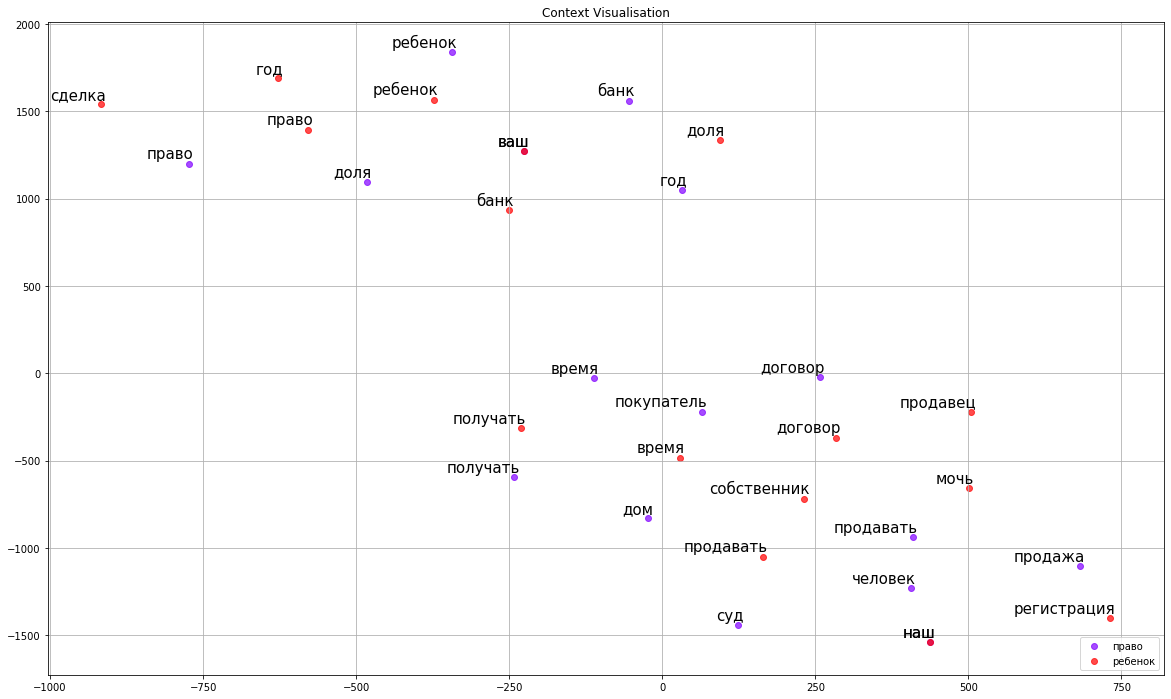

In [22]:
test.visualise_context(['право', "ребенок"], 15)

15 наиболее часто встречающихся слов контекста

приватизация :  39
право :  32
год :  19
отец :  16
зарегистрировать :  16
родитель :  14
мать :  13
проживать :  12
место :  12
покупать :  9
жить :  9
иметь :  9
доля :  9
приватизировать :  9
пользование :  9


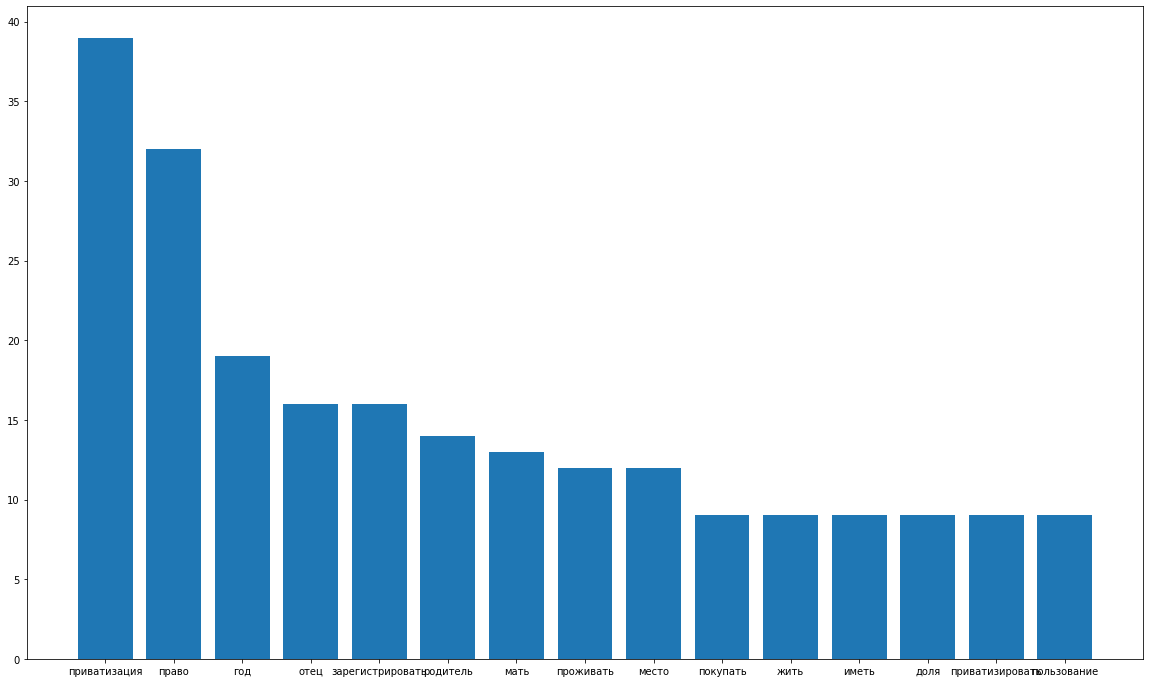

In [6]:
test.context('ребенок', k=15, ngram=1)

10 наиболее часто встречающихся слов

сделка :  164
право :  149
ребенок :  142
клиент :  124
год :  121
мочь :  114
покупатель :  113
человек :  107
продавец :  92
знать :  88


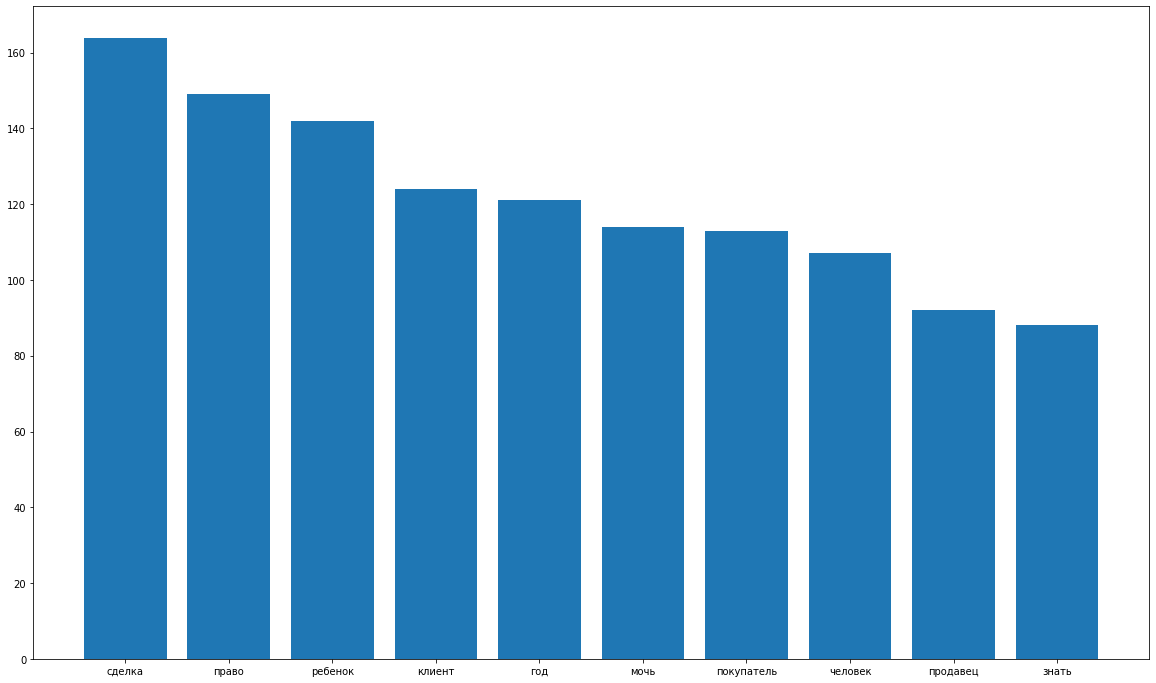

In [7]:
test.frequency(10, 'comment', start_date=[28,9,2020])

In [20]:
test.word_counter.most_common(3)[0]

('сделка', 164)

In [8]:
test.date_unique(15, start_date=[3,10,2020])

15 самых значимых слов для данного промежутка

1: сделка
2: клиент
3: покупатель
4: мочь
5: собственник
6: человек
7: писать
8: вообще
9: доля
10: делать
11: новый
12: туалет
13: давать
14: нужно
15: знать


In [9]:
test.date_top('comment', 1)

Самое частое слово за день

no comments 2019-10-31 

[('клиент', 2)] 2020-01-10 

[('Chukreev', 1)] 2020-08-25 

[('консульство', 7)] 2020-08-31 

[('кореец', 10)] 2020-09-18 

[('никольский', 1)] 2020-09-21 

[('пристав', 4)] 2020-09-23 

[('доля', 4)] 2020-09-24 

[('живой', 2)] 2020-09-26 

no comments 2020-09-28 

[('паспорт', 14)] 2020-09-29 

[('росреестр', 8)] 2020-09-30 

[('год', 44)] 2020-10-01 

[('сделка', 54)] 2020-10-02 

[('ребенок', 70)] 2020-10-03 

[('окно', 16)] 2020-10-04 

[('сделка', 23)] 2020-10-05 



In [10]:
test.context('право', k = 20, ngram=2)

не работает, извините(


In [11]:
test.word_in_time('право')

<Figure size 1368x1080 with 0 Axes>

In [22]:
list(ngrams(df['comment'][1][0],2))

[(('документ', 'регистрировать'), ('регистрировать', 'регистратор'))]

In [23]:
for i in range(len(df)):
    for j in range(len(df['comment'][i])):
        df['comment'][i][j] = list(ngrams(df['comment'][i][j],2))
for i in range(len(df)):
    df['post'][i] = list(ngrams(df['post'][i],2))

In [24]:
[1for i in range(len(df)):
    for f in range(len(df['comment'][i])):
        j = 0
        try:
            index = df['comment'][i][f][j:].index(word)
            if index>k:
                if len(df['comment'][i][f][j:][index:])>k:
                    context_ls = df['comment'][i][f][j:][index-k:index+k]
                elif len(df['comment'][i][f][j:][index:])<=k:
                    context_ls = df['comment'][i][f][j:][index-k:]
            elif index<=k:
                if len(df['comment'][i][f][j:][index:])>k:
                    context_ls = df['comment'][i][f][j:][:index+k]
                elif len(df['comment'][i][f][j:][index:])<=k:
                    context_ls = df['comment'][i][f][j:][:]
            closest_post.append(context_ls)
            j = index
        except ValueError:
            continue



SyntaxError: invalid syntax (<ipython-input-24-749dc077255c>, line 1)

In [25]:
closest_post

NameError: name 'closest_post' is not defined

In [26]:
wordcount = {}
for word in (suka):   
    if word not in sum_noise:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
print("The {} most common words are as follows\n".format(15))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(15):
       print(word, ": ", count)

NameError: name 'suka' is not defined

In [27]:
df = pd.read_csv('fb.csv', index_col=0)

In [28]:
tokeniz(df)

In [29]:
df1 = deepcopy(df)

In [30]:
a = [7, 3, 4]
b = a
c = a[:]
b[0] = 10
print ('a: ', a, id(a))
print ('b: ', b, id(b))
print ('c: ', c, id(c))


a:  [10, 3, 4] 140151244771488
b:  [10, 3, 4] 140151244771488
c:  [7, 3, 4] 140151244775504


In [31]:
id(test.df), id(df)

(140151256509584, 140151246707216)

In [32]:
test.df['post'][1]=['xuy']

In [33]:
df

,time,post,number_comments,comment
0,2020-10-01 00:00:00,"[размещать, видео, судебный, юрист, татьяна, п...",9,"[[очепятка, прочитывать, аккультный], [чубатов..."
1,2020-10-05 00:00:00,"[клиент, спрашивать, оплачивать, проверка, сбе...",2,"[[документ, регистрировать, регистратор], [ден..."
2,2020-10-05 00:00:00,"[приплывать, сделка, цепь, нижний, просить, за...",5,"[[итакасоглашаться, оценщик, ссылка, присылать..."
3,2020-10-05 00:00:00,"[добрый, день, нужный, помощь, нужный, фото, о...",52,"[[америка, работать], [наташа], [лурье], [вспо..."
4,2020-10-05 00:00:00,"[время, приходить, покупатель, предлагать, зап...",10,"[[распашонка], [лукашевский], [банк], [быков],..."
...,...,...,...,...
107,2020-10-01 00:00:00,"[поделиться, пожалуйста, опыт, недавно, оформл...",0,[]
108,2020-10-01 00:00:00,"[поступать, ситуация, стоять, связываться, про...",0,[]
109,2019-10-31 00:00:00,"[пост, благодарность, серебряков, андрей, имет...",0,[]
110,2020-10-01 00:00:00,"[среди, волшебник, смочь, срочно, пресрочно, п...",0,[]


In [34]:
test.df1 = test.df

In [35]:
for i in range(len(test.df1)):
    for j in range(len(test.df1['comment'][i])):
        test.df1['comment'][i][j] = list(ngrams(test.df1['comment'][i][j],2))

In [36]:
id(test.df), id(test.df1), id(df)

(140151256509584, 140151256509584, 140151246707216)

In [37]:
det = TreebankWordDetokenizer()
a = [det.detokenize(df['post'][1]), det.detokenize(df['post'][2])]

In [38]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(a)

In [39]:
tt = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [40]:
np.sort(pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names()))[::-1][:2]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.37796447,
        0.37796447, 0.37796447, 0.37796447, 0.37796447, 0.37796447,
        0.37796447],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.17407766, 0.17407766, 0.17407766,
        0.17407766, 0.17407766, 0.17407766, 0.17407766, 0.17407766,
        0.17407766, 0.17407766, 0.17407766, 0.17407766, 0.17407766,
        0.17407766, 0.17407766, 0.17407766, 0.34815531, 0.34815531,
        0.52223297]])

In [41]:
tt

,висеть,витрина,все,делать,доллар,еще,закладывать,замечание,кабинет,клиент,...,приходиться,проверка,пропадать,просить,сбера,сделка,спрашивать,теперь,цепь,якобы
0,0.328798,0.164399,0.164399,0.164399,0.000000,0.164399,0.000000,0.164399,0.164399,0.164399,...,0.164399,0.164399,0.164399,0.000000,0.164399,0.000000,0.164399,0.164399,0.000000,0.164399
1,0.000000,0.000000,0.000000,0.000000,0.377964,0.000000,0.377964,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.377964,0.000000,0.377964,0.000000,0.000000,0.377964,0.000000


In [51]:
dick = dict(zip(tt.columns, tt.loc[1]))

In [49]:
for i in range(len(test.df)):
    for j in range(len(test.df['comment'][i])):
        test.df['comment'][i][j] = list(ngrams(test.df['comment'][i][j],2))
for i in range(len(test.df)):
    test.df['post'][i] = list(ngrams(test.df['post'][i],2))

In [45]:
test.df['post'][1] = list(ngrams(test.df['post'][1],2))

In [50]:
test.df

,time,post,number_comments,comment
0,2020-10-01 00:00:00,"[(коллега, размещать), (размещать, видео), (ви...",9,"[[], [], [], [(((('большой', 'привет'), ('прив..."
1,2020-10-05 00:00:00,"[(коллега, клиент), (клиент, спрашивать), (спр...",2,"[[], []]"
2,2020-10-05 00:00:00,"[(приплывать, сделка), (сделка, цепь), (цепь, ...",5,"[[((('итакасоглашаться', 'оценщик'), ('оценщик..."
3,2020-10-05 00:00:00,"[(коллега, добрый), (добрый, день), (день, нуж...",52,"[[], [], [], [], [], [], [], [], [((('авансовы..."
4,2020-10-05 00:00:00,"[(время, такой), (такой, приходить), (приходит...",10,"[[], [], [], [], [], [((('давать', 'торг'), ('..."
...,...,...,...,...
107,2020-10-01 00:00:00,"[(уважаемый, коллега), (коллега, поделиться), ...",0,[]
108,2020-10-01 00:00:00,"[(уважаемый, коллега), (коллега, поступать), (...",0,[]
109,2019-10-31 00:00:00,"[(пост, благодарность), (благодарность, серебр...",0,[]
110,2020-10-01 00:00:00,"[(среди, волшебник), (волшебник, который), (ко...",0,[]


In [55]:
a

' коллега размещать видео судебный юрист татьяна пак мы поговорить процедура банкротство физический лицо посмотреть именно глаз этот процедура заниматься надеяться вы интересный ссылка видео первый комментарий мой пост тема актуальный возникать вопрос риэлтор особенно защищать покупатель законобанкротствефизическихлица обучениериэлтор юристпонедвижимость коллега клиент спрашивать оплачивать проверка сбера якобы надежно теперь кабинет висеть красный замечание отчет оценка объект висеть витрина отчет оценка все пропадать еще оценка делать приходиться обходиться приплывать сделка цепь нижний просить закладывать доллар коллега добрый день нужный помощь нужный фото оценка квартира данный планировка помогать время такой приходить покупатель квартира предлагать заплатить квартира предлагаться реклама хотеться дорогой коллега такой предложение передаваться собственник говориться нет отдавать квартира приходить рано приходить повторно неудобно раз ездить тот другой предлагать еще повышать тяжел

In [82]:
df_d = df[df['time']<datetime(2020,10,5,0,0)]

In [70]:
df_nd = deepcopy(df[~(df['time']<datetime(2020,10,5,0,0))])

In [128]:
df_d.index = np.arange(len(df_d))
d = ''
for i in range(len(df_d)):
    d += ' ' + det.detokenize(df_d['post'][i])
for i in range(len(df_d)):
    for j in range(len(df_d['comment'][i])):
        d += ' ' + det.detokenize(df_d['comment'][i][j])
df_nd.index = np.arange(len(df_nd))
nd = ''
for i in range(len(df_nd)):
    nd += ' ' + det.detokenize(df_nd['post'][i])
for i in range(len(df_nd)):
    for j in range(len(df_nd['comment'][i])):
        nd += ' ' + det.detokenize(df_nd['comment'][i][j])

In [129]:
ls_dt = [d, nd]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(ls_dt)
tt = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [130]:
tt

,aln,alyakina,anchevskaya,anews,app,arendator,awards,ba,balashova,be,...,ялта,янао,яндекс,янчиков,ясинский,яснение,ясно,ясный,яхрома,ячейка
0,0.001407,0.001407,0.002814,0.000000,0.001407,0.002814,0.002814,0.001407,0.001001,0.007035,...,0.001407,0.001407,0.004221,0.002814,0.002814,0.001407,0.004221,0.002814,0.001407,0.008009
1,0.000000,0.000000,0.000000,0.009564,0.000000,0.000000,0.000000,0.000000,0.020414,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006805


In [132]:
dick = dict(zip(tt.columns, tt.loc[0]))
utp = sorted(dick, key=dick.get, reverse=True)
for i in range(15):
    print('{}:'.format(i+1)+' '+utp[i])

1: квартира
2: еще
3: сделка
4: такой
5: ребенок
6: право
7: вы
8: год
9: клиент
10: то
11: который
12: покупатель
13: мочь
14: свой
15: продавец


In [89]:
df_d.index, np.arange(len(df))

(Int64Index([  0,   8,  11,  12,  15,  16,  17,  18,  19,  21,  22,  23,  24,
              25,  27,  28,  29,  30,  31,  32,  33,  34,  36,  37,  38,  39,
              40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
              53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
              66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
              79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
              92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
             105, 106, 107, 108, 109, 110, 111],
            dtype='int64'),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,

In [92]:
df.iloc[np.delete(np.arange(len(df)), df_d.index),:]

,time,post,number_comments,comment
1,2020-10-05 00:00:00,"[коллега, клиент, спрашивать, оплачивать, пров...",2,"[[документ, регистрировать, регистратор], [ден..."
2,2020-10-05 00:00:00,"[приплывать, сделка, цепь, нижний, просить, за...",5,"[[итакасоглашаться, оценщик, ссылка, присылать..."
3,2020-10-05 00:00:00,"[коллега, добрый, день, нужный, помощь, нужный...",52,"[[америка, работать], [наташа], [лурье], [вспо..."
4,2020-10-05 00:00:00,"[время, такой, приходить, покупатель, квартира...",10,"[[распашонка], [лукашевский], [банк], [быков],..."
5,2020-10-05 00:00:00,"[добрый, утро, нбки, кто-то, быстро, сделать, ...",35,"[[предлагать, выходить, собственник, обход, аг..."
6,2020-10-05 00:00:00,"[коллега, добрый, утро]",6,"[[давно, отказываться, завышение, ну, вариант,..."
7,2020-10-05 00:00:00,"[что, коллега, это, реклама, один, квартира]",14,"[[узнавать], [Shuk, завышение, договор, просит..."
9,2020-10-05 00:00:00,"[утро, позвонить, попросить, поработать, нужно...",10,"[[вот, понимать, мочь, текст, пост], [земля, н..."
10,2020-10-05 00:00:00,"[уважаемый, коллега, кто, подобный, ситуация, ...",15,"[[земля, поменять, адрес], [нужно, брать, расп..."
13,2020-10-05 00:00:00,"[прекрасно, удалять, твой, публикация, давать,...",70,"[[добрянский, какой, ремонт, речь, вы, последн..."


In [14]:
!brew install wget

wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

SyntaxError: invalid syntax (<ipython-input-14-59074aaf9d89>, line 3)

In [12]:
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

FileNotFoundError: [Errno 2] No such file or directory: 'GoogleNews-vectors-negative300.bin'